# Modeling
We make forecasting models for our Power BI Report.

In [1]:
import pandas as pd

path = "../data/"
data = pd.read_csv(path+"processed/data.csv")
data.head()

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,...,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
0,211133,canceled,2016-07-01,kccBuy2FreyAirFreshenerGet1KasualBodySprayFree,240.0,1.0,240.0,100147444,Beauty & Grooming,False,...,cod,2016-07-01,Gross,240.0,2016,7,2016-07-01,2016-07-01,FY17,2
1,211134,canceled,2016-07-01,EgoUP0017999MR0,2450.0,1.0,2450.0,100147445,Women's Fashion,False,...,cod,2016-07-01,Gross,2450.0,2016,7,2016-07-01,2016-07-01,FY17,3
2,211135,complete,2016-07-01,kcckronedeal,360.0,1.0,60.0,100147446,Beauty & Grooming,True,...,cod,2016-07-01,Net,360.0,2016,7,2016-07-01,2016-07-01,FY17,4
3,211136,refunded,2016-07-01,BK7010400AG,555.0,2.0,1110.0,100147447,Soghaat,False,...,cod,2016-07-01,Valid,1110.0,2016,7,2016-07-01,2016-07-01,FY17,5
4,211137,canceled,2016-07-01,UKNamkinoAllInOne200Gms,80.0,1.0,80.0,100147448,Soghaat,False,...,cod,2016-07-01,Gross,80.0,2016,7,2016-07-01,2016-07-01,FY17,6


# Data Preparation

## Time Series
Convert raw data to time series data.

Note, we consider each individual item as an order, so multiple items by same customer will be considered separate orders.

In [2]:
orders = data[["created_at", "item_id"]]
orders.columns = ["Date", "Total"]

orders = orders.groupby("Date")["Total"].count()

orders.head()

Date
2016-07-01    528
2016-07-02    254
2016-07-03    203
2016-07-04    216
2016-07-05    164
Name: Total, dtype: int64

In [3]:
revenue = data[["created_at", "grand_total"]]
revenue.columns = ["Date", "Total"]

revenue = revenue.groupby("Date")["Total"].sum()

revenue.head()

Date
2016-07-01    1284503.75
2016-07-02    1394837.48
2016-07-03    2143719.88
2016-07-04    1094068.25
2016-07-05     910507.50
Name: Total, dtype: float64

In [4]:
new_customers = data[["Customer Since", "Customer ID"]]
new_customers.columns = ["Date", "Total"]

print(data.shape[0])
print(len(data["Customer ID"].unique()))
print(new_customers.duplicated().sum())
print(len(data["Customer ID"].unique()) + new_customers.duplicated().sum())

print(new_customers.shape[0])
new_customers = new_customers.drop_duplicates()
print(new_customers.shape[0])

new_customers = new_customers.groupby("Date")["Total"].count()

new_customers.head()

576480
114211
462269
576480
576480
114211


Date
2016-07-01     2374
2016-08-01     3065
2016-09-01     4483
2016-10-01     2361
2016-11-01    14373
Name: Total, dtype: int64

Incomplete purchases comprise of all unfullfilled orders, e.g refunds, cancellation, payment failure etc.

In [5]:
incomplete_purchases = data[["created_at", "status"]]

print(incomplete_purchases.shape[0])
incomplete_purchases = incomplete_purchases[incomplete_purchases["status"] != "complete"]
incomplete_purchases = incomplete_purchases[incomplete_purchases["status"] != "received"]
incomplete_purchases = incomplete_purchases[incomplete_purchases["status"] != "payment_review"]
print(incomplete_purchases.shape[0])

incomplete_purchases.columns = ["Date", "Total"]
incomplete_purchases = incomplete_purchases.groupby("Date")["Total"].count()

incomplete_purchases.head()

576480
268815


Date
2016-07-01    167
2016-07-02    114
2016-07-03    113
2016-07-04     77
2016-07-05     69
Name: Total, dtype: int64

In [6]:
orders_by_cat = data[["created_at", "item_id", "category_name_1"]]
orders_by_cat.columns = ["Date", "Item ID", "Product Category"]

orders_by_cat = orders_by_cat.groupby(["Date", "Product Category"])["Item ID"].count()
orders_by_cat = pd.DataFrame(orders_by_cat).reset_index().pivot(columns=["Product Category"], index=["Date"])
orders_by_cat = orders_by_cat.fillna(0)

def col_name_correct(tup):
    return tup[1]
orders_by_cat.columns = orders_by_cat.columns.map(col_name_correct)

orders_by_cat.head()

,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Women's Fashion
Date,,,,,,,,,,,,,,,
2016-07-01,16.0,237.0,0.0,6.0,1.0,2.0,15.0,15.0,44.0,23.0,5.0,0.0,131.0,1.0,32.0
2016-07-02,14.0,43.0,1.0,12.0,2.0,4.0,13.0,9.0,42.0,25.0,1.0,0.0,80.0,0.0,8.0
2016-07-03,3.0,22.0,0.0,7.0,0.0,9.0,10.0,5.0,28.0,8.0,0.0,0.0,92.0,0.0,19.0
2016-07-04,9.0,38.0,0.0,8.0,2.0,3.0,10.0,7.0,40.0,15.0,3.0,7.0,65.0,0.0,9.0
2016-07-05,2.0,29.0,0.0,8.0,2.0,3.0,18.0,4.0,20.0,12.0,1.0,15.0,41.0,0.0,9.0


Note, we might have missing days. So lets correct that.

In [7]:
def get_days(series, date_col):
    df = pd.DataFrame(series).reset_index()
    dates = pd.DataFrame(pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq="D"))
    dates.columns = [date_col]
    return dates

def get_months(series, date_col):
    df = pd.DataFrame(series).reset_index()
    dates = pd.DataFrame(pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq="MS"))
    dates.columns = [date_col]
    return dates

In [8]:
print((orders.shape[0] / (get_days(orders, "Date").shape[0])) * 100) 
print((revenue.shape[0] / (get_days(revenue, "Date").shape[0])) * 100)
print((new_customers.shape[0] / (get_months(new_customers, "Date").shape[0])) * 100)
print((incomplete_purchases.shape[0] / (get_days(incomplete_purchases, "Date").shape[0])) * 100)
print((orders_by_cat.shape[0] / (get_days(orders_by_cat, "Date").shape[0]*15)) * 100)

100.0
100.0
100.0
100.0
6.666666666666667


In [9]:
def complete_dates(series, date_col, days=True):
    """
        series:
            [pd.Series]
            Needs to be of structure such that index are an iso standard date and values column for pd.Series

        date_col:
            [String]
            Name of index column for pd.Series or name of dates column for pd.DataFrame
    """
    
    dates = None
    if days:
        dates = get_days(series, date_col)
    else:
        dates = get_months(series, date_col)

    df = pd.DataFrame(series).reset_index()
    df[date_col] = pd.to_datetime(df[date_col])
    df = dates.merge(df, left_on=date_col, right_on=date_col, how="left")
    df.fillna(0)
    return df

In [10]:
orders = complete_dates(orders, "Date", days=True)
revenue = complete_dates(revenue, "Date", days=True)
new_customers = complete_dates(new_customers, "Date", days=False)
incomplete_purchases = complete_dates(incomplete_purchases, "Date", days=True)
orders_by_cat = complete_dates(orders_by_cat, "Date")

orders_by_cat = orders_by_cat.fillna(0)

We have the following datframes.<br>
`orders`, `revenue`, `new_customers`, `incomplete_purchases`, `orders_by_cat`

## Supervised Learning
Convert time series data to correct format for use in supervised learning tasks.

# Testing ARIMA
We expect, that there exists trends in the data. That the variance is not constant and data might not be seasonal. Hence data is not stationary.<br>
Lets first test our assumption that ARIMA cannot be used, then we can safely move onto other methods.

In [44]:
from statsmodels.tsa.stattools import adfuller

def test_adfuller(series):
    result = adfuller(series)
    return (float(result[0]), float(result[1]))

print("orders\t\t", test_adfuller(orders.set_index("Date")))
print("revenue\t\t", test_adfuller(revenue.set_index("Date")))
print("new_customers\t\t", test_adfuller(new_customers.set_index("Date")))
print("incomplete_purchases\t\t", test_adfuller(incomplete_purchases.set_index("Date")))

orders		 (-7.660450471648832, 1.694191465577029e-11)
revenue		 (-6.734911652603243, 3.2258042470167883e-09)
new_customers		 (-5.523972031046116, 1.8505489608608945e-06)
incomplete_purchases		 (-7.787043446419364, 8.127465540531725e-12)


In [43]:
for col in orders_by_cat.columns:
    print("orders by category", col, "\t\t", test_adfuller(orders_by_cat[col]))

orders by category Date 		 (0.8481677797008773, 0.9923752128705913)
orders by category Appliances 		 (-6.799402421210216, 2.257179754884077e-09)
orders by category Beauty & Grooming 		 (-6.1564521709179045, 7.34868624609238e-08)
orders by category Books 		 (-10.830515412290058, 1.7128605149786078e-19)
orders by category Computing 		 (-12.078471988877125, 2.2611154435345695e-22)
orders by category Entertainment 		 (-7.380395528174469, 8.502678437260432e-11)
orders by category Health & Sports 		 (-9.052955283502865, 4.784925136051554e-15)
orders by category Home & Living 		 (-7.758606201296861, 9.587971003607416e-12)
orders by category Kids & Baby 		 (-7.429493018511284, 6.416507935422934e-11)
orders by category Men's Fashion 		 (-7.481233567742622, 4.766357360110047e-11)
orders by category Mobiles & Tablets 		 (-7.692671966116926, 1.4056915821790877e-11)
orders by category Others 		 (-5.369255791531396, 3.928976374393359e-06)
orders by category School & Education 		 (-7.030988857032432,

Contrary to our belief, all of them seem are stationary according to their teest statistic (tuple[0]) and p-value (tuple[1]).

In [89]:
print(orders["Total"].max())
print(revenue["Total"].max())
print(new_customers["Total"].max())
print(incomplete_purchases["Total"].max())

14929
156231274.805
16714
6805


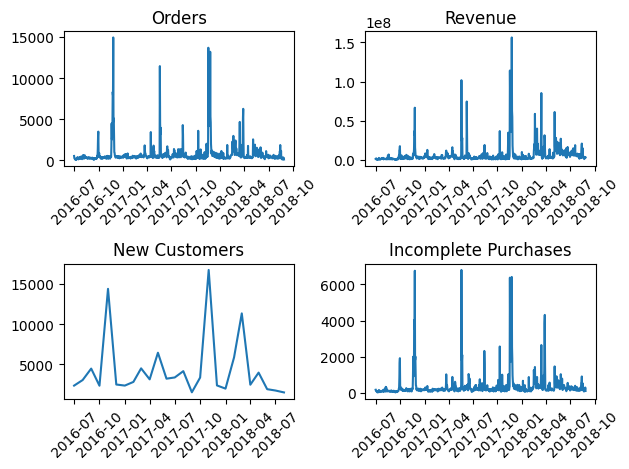

In [103]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, sharey=False)
ax[0, 0].plot(orders["Date"], orders["Total"])
ax[0, 0].set_title("Orders")

ax[0, 1].plot(revenue["Date"], revenue["Total"])
ax[0, 1].set_title("Revenue")

ax[1, 0].plot(new_customers["Date"], new_customers["Total"])
ax[1, 0].set_title("New Customers")

ax[1, 1].plot(incomplete_purchases["Date"], incomplete_purchases["Total"])
ax[1, 1].set_title("Incomplete Purchases")

for a in ax.flat:
    a.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

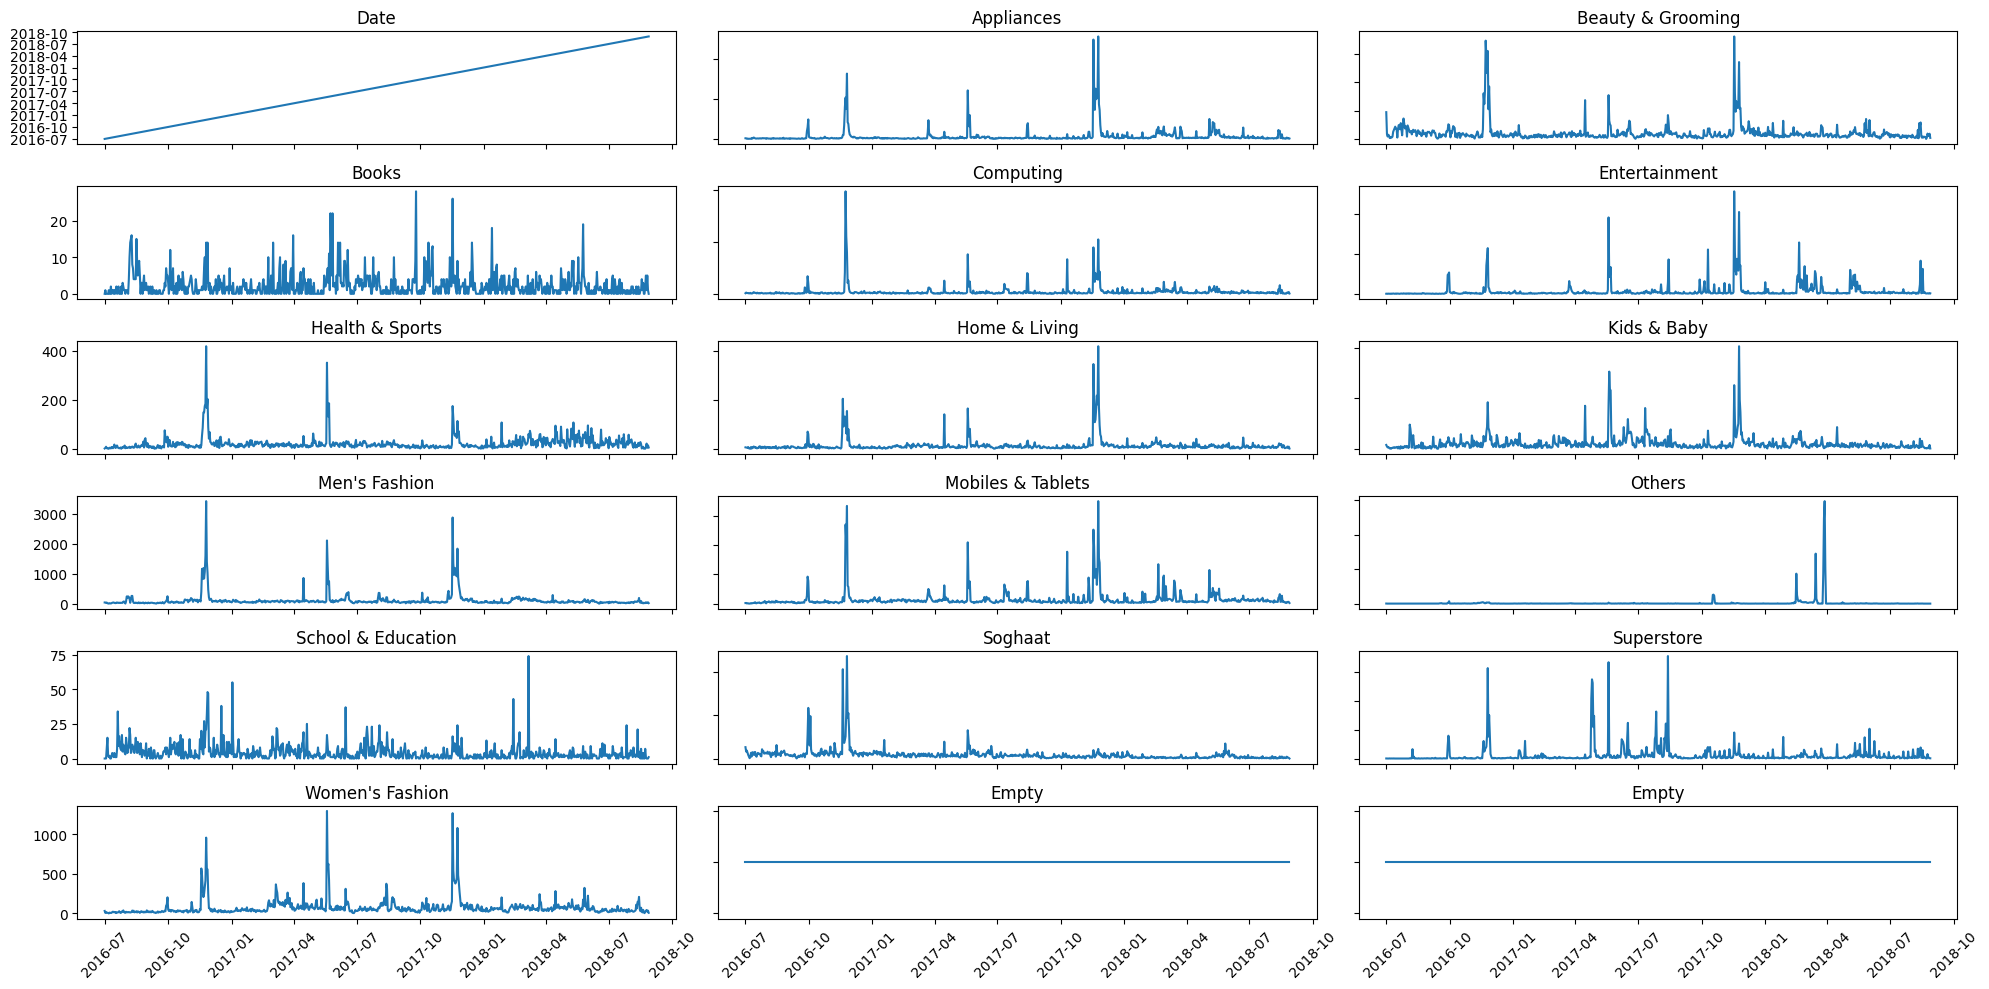

In [133]:
import math

fig, ax = plt.subplots((math.floor(len(orders_by_cat.columns)/3)) + 1, 3, sharey=False)
col_to_plot = orders_by_cat.columns
itr = 0
for ax_row in ax:
    for ax_item in ax_row:
        if itr < len(col_to_plot):
            ax_item.plot(orders_by_cat["Date"], orders_by_cat[col_to_plot[itr]])
            ax_item.set_title(col_to_plot[itr])
        else:
            ax_item.plot(orders_by_cat["Date"], [0]*orders_by_cat.shape[0])
            ax_item.set_title("Empty")
        itr += 1

for a in ax.flat:
    a.tick_params(axis='x', rotation=45)

fig.set_figwidth(20)
fig.set_figheight(10)

for a in fig.get_axes():
    a.label_outer()
fig.tight_layout()
plt.show()

# ARIMA Models
We use the ARIMA models to forecast future values.

# XGBoost Models
We use the XGBRegressor to forecast future values.

# Export Forecasts